# 2) Packages

In [46]:
require(RCurl) #To read databases from htlm websites
require(car) #Scatterplots

# 3) Data handling

## a) Codebook

In [47]:
# group
# obs
# arc: bike lane 
# period: periods of 15 minutes of data collection
# length: length of the bike lane
# ff_tt: free frow travel time
# tt: travel time
# ncyclists: cyclist counted in each 15 minutes period.

## b) Data reading

In [48]:
df<-read.csv(text=getURL("https://raw.githubusercontent.com/paguarda/FIT/master/Taller2/data.csv"), fill = TRUE, header = TRUE,na.strings=c("NA","NaN", " "))

In [49]:
head(df)

group,obs,arc,period,dir,length,ff_tt,tt,ncyclists
1,1,1,1,1,130,41.03,21.59,3
1,2,1,2,1,130,41.03,34.99,3
1,3,1,3,1,130,41.03,22.99,5
1,4,1,4,1,130,41.03,19.63,1
1,5,1,5,1,130,41.03,15.96,2
1,6,1,6,1,130,41.03,20.04,4


## c) Data formatting

### Units

In [50]:
#Length
df$length <- df$length/1000 #km

#Flow
df$flow <- df$ncyclists*4 #number of cyclists per hour
max_flow <- 2000 #cyclists/hr

#Travel time
df$tt <- as.numeric(as.character(df$tt))
df$tt <- df$tt/3600 #hr

#Free flow travel time
df$ff_tt <- as.numeric(as.character(df$ff_tt))
df$ff_tt <- df$ff_tt/3600 #hr

Warning message in eval(expr, envir, enclos):
“NAs introducidos por coerción”

###  New variables

In [51]:
df$ff_speed <- df$length/df$tt #Free flow speed

In [52]:
df$t_speed <- df$ff_speed/2*(1+sqrt(1-df$flow/max_flow)) #Theorethical speed

In [53]:
df$t_tt <- df$length/df$t_speed #Theorethical travel time 

# 4) Descriptive statistics

In [54]:
summary(df)

     group           obs          arc            period          dir     
 Min.   :1.00   Min.   : 1   Min.   :1.000   Min.   :1.00   Min.   :1.0  
 1st Qu.:2.75   1st Qu.: 4   1st Qu.:1.750   1st Qu.:2.75   1st Qu.:1.0  
 Median :4.50   Median : 8   Median :3.500   Median :4.50   Median :1.5  
 Mean   :4.50   Mean   : 8   Mean   :3.625   Mean   :4.50   Mean   :1.5  
 3rd Qu.:6.25   3rd Qu.:12   3rd Qu.:5.250   3rd Qu.:6.25   3rd Qu.:2.0  
 Max.   :8.00   Max.   :16   Max.   :7.000   Max.   :8.00   Max.   :2.0  
                                                                         
     length            ff_tt                tt             ncyclists     
 Min.   :0.05400   Min.   :0.002028   Min.   :0.000000   Min.   : 0.000  
 1st Qu.:0.09225   1st Qu.:0.004049   1st Qu.:0.004722   1st Qu.: 3.000  
 Median :0.11000   Median :0.004332   Median :0.005747   Median : 6.000  
 Mean   :0.10712   Mean   :0.004894   Mean   :0.005737   Mean   : 6.953  
 3rd Qu.:0.13000   3rd Qu.:0.005245   

In [55]:
# Free flow travel time by group

# 5) Regression

## BPR variables

### Dependent variable 

In [56]:
df$yBPR <- with(df,log(tt-ff_tt)) #(based on real travel times)

Warning message in log(tt - ff_tt):
“Se han producido NaNs”

In [57]:
df$ytBPR <- with(df,log(t_tt-ff_tt)) #(based on theoretical travel times)

Warning message in log(t_tt - ff_tt):
“Se han producido NaNs”

### Independent variable

In [58]:
df$xBPR <- with(df,log(flow/max_flow))

### Removing Na's

In [59]:
df <- subset(df,!is.na(yBPR) & yBPR != -Inf)
df <- subset(df,!is.na(xBPR))

### Linear regression

#### Regular

In [60]:
lmBPR <- lm(yBPR~xBPR, data = subset(df))

In [61]:
dim(df)

[1] 104  16

In [62]:
summary(lmBPR)


Call:
lm(formula = yBPR ~ xBPR, data = subset(df))

Residuals:
    Min      1Q  Median      3Q     Max 
-4.5621 -0.4907  0.1754  0.6972  2.4835 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -5.6751     0.5658 -10.030   <2e-16 ***
xBPR          0.2541     0.1241   2.048   0.0431 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.016 on 102 degrees of freedom
Multiple R-squared:  0.03949,	Adjusted R-squared:  0.03008 
F-statistic: 4.194 on 1 and 102 DF,  p-value: 0.04314


#### Fixed slope

In [63]:
beta <- 1.2
lmBPR_FS <- lm(yBPR~offset(beta * xBPR), data = subset(df))

In [64]:
summary(lmBPR_FS)


Call:
lm(formula = yBPR ~ offset(beta * xBPR), data = subset(df))

Residuals:
    Min      1Q  Median      3Q     Max 
-4.4518 -0.7608 -0.0133  0.6869  4.1161 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -1.4295     0.1242  -11.51   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.267 on 103 degrees of freedom


# 6) Plots

## Function to make predictions according to BPR

In [65]:


bpr_prediction <- function(group, regression, max_flow = max_flow){
    
    qmax <- max_flow
    tf <- mean(df[df$group == group,]$ff_tt)
    
    alpha <- exp(as.numeric(regression$coefficients[1]))/(tf)
    beta <- regression$coefficients[2]
    
    xCurve_flow <- seq(1, 2000, 10)
    yCurve_tt <- tf*(1+alpha*(xCurve_flow/qmax)^(beta))
    
    return(data.frame(group, xCurve_flow,yCurve_tt))
    
}

bpr_prediction_fs <- function(group, regression, fs, max_flow = max_flow){
    
    qmax <- max_flow
    tf <- mean(df[df$group == group,]$ff_tt)
    
    alpha <- exp(as.numeric(regression$coefficients[1]))/(tf)
    beta <- fs
    
    xCurve_flow <- seq(1, 220, 10)
    yCurve_tt <- tf*(1+alpha*(xCurve_flow/qmax)^(beta))
    
    return(data.frame(group, xCurve_flow,yCurve_tt))
    
}


## BPR Curves

In [66]:
#Free slope
BPRCurveByGroup <- lapply(1:8, function(i) bpr_prediction(group = i, regression = lmBPR, max_flow = max_flow))
                          
xCurve_flow <- BPRCurveByGroup[[2]][[2]]

yCurve_tt_g1 <- BPRCurveByGroup[[1]][[3]]
yCurve_tt_g2 <- BPRCurveByGroup[[2]][[3]]
yCurve_tt_g3 <- BPRCurveByGroup[[3]][[3]]
yCurve_tt_g4 <- BPRCurveByGroup[[4]][[3]]
yCurve_tt_g5 <- BPRCurveByGroup[[5]][[3]]
yCurve_tt_g6 <- BPRCurveByGroup[[6]][[3]]
yCurve_tt_g7 <- BPRCurveByGroup[[7]][[3]]
yCurve_tt_g8 <- BPRCurveByGroup[[8]][[3]]


#Fixed slope
BPRCurveByGroupFS <- lapply(1:8, function(i) bpr_prediction_fs(group = i, regression = lmBPR_FS, fs = beta, max_flow = max_flow))
                          
xCurve_flow_FS <- BPRCurveByGroupFS[[2]][[2]]

yCurve_tt_g1_FS <- BPRCurveByGroupFS[[1]][[3]]
yCurve_tt_g2_FS <- BPRCurveByGroupFS[[2]][[3]]
yCurve_tt_g3_FS <- BPRCurveByGroupFS[[3]][[3]]
yCurve_tt_g4_FS <- BPRCurveByGroupFS[[4]][[3]]
yCurve_tt_g5_FS <- BPRCurveByGroupFS[[5]][[3]]
yCurve_tt_g6_FS <- BPRCurveByGroupFS[[6]][[3]]
yCurve_tt_g7_FS <- BPRCurveByGroupFS[[7]][[3]]
yCurve_tt_g8_FS <- BPRCurveByGroupFS[[8]][[3]]


## Plots by group

In [67]:
#Free parameters

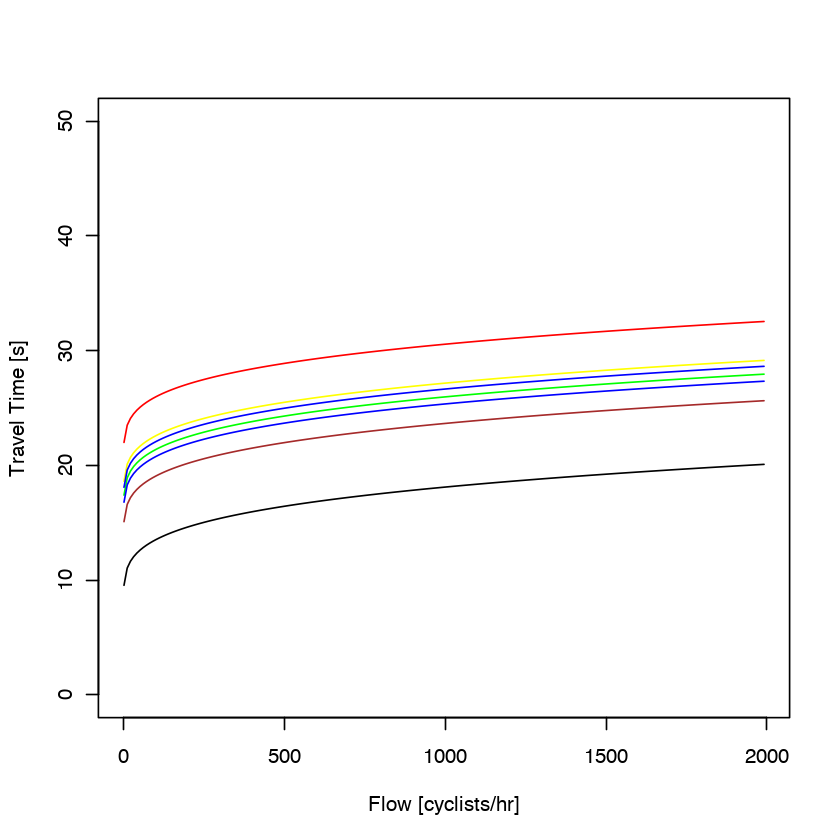

In [68]:
factorScale<-3600

options(jupyter.plot_mimetypes = 'image/png')

#Plot group 1
plot(xCurve_flow,factorScale*yCurve_tt_g1
    , ylim = c(0,50)
    , col = 'orange', lty = 1
    , ylab = "Travel Time [s]", xlab = "Flow [cyclists/hr]")
#plot(tt ~ flow, data=df, xlab="Flow [cyclists/hour]", ylab="Travel Time [s]", 
#   main="Scatter Plot"
#    #, xlim = c(0,1000), ylim = c(0,60)
#    )



lines(xCurve_flow, factorScale*yCurve_tt_g2, col = 'red', lty = 1) # BPR curve group 2
lines(xCurve_flow, factorScale*yCurve_tt_g3, col = 'black', lty = 1) # BPR curve group 3
lines(xCurve_flow, factorScale*yCurve_tt_g4, col = 'yellow', lty = 1) # BPR curve group 4
lines(xCurve_flow, factorScale*yCurve_tt_g5, col = 'green', lty = 1) # BPR curve group 5
lines(xCurve_flow, factorScale*yCurve_tt_g6, col = 'brown', lty = 1) # BPR curve group 6
lines(xCurve_flow, factorScale*yCurve_tt_g7, col = 'blue', lty = 1) # BPR curve group 7
lines(xCurve_flow, factorScale*yCurve_tt_g8, col = 'blue', lty = 1) # BPR curve group 8

In [69]:
# Fixed parameter

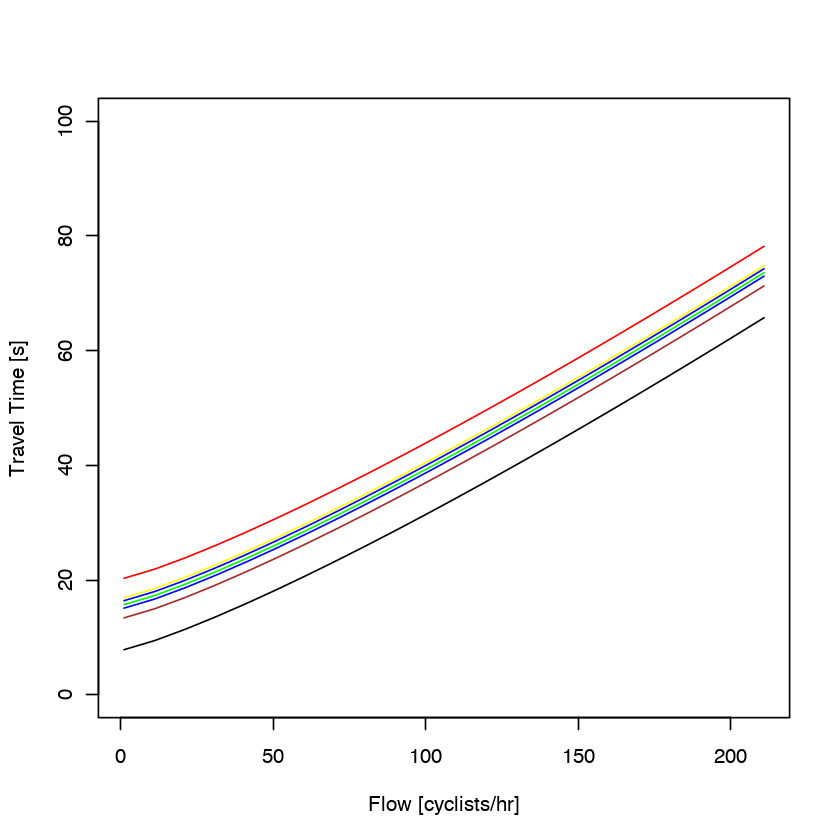

In [70]:
factorScale<-3600

options(jupyter.plot_mimetypes = 'image/png')

#Plot group 1
plot(xCurve_flow_FS,factorScale*yCurve_tt_g1_FS
    , ylim = c(0,100)
    , col = 'orange', lty = 1
    , ylab = "Travel Time [s]", xlab = "Flow [cyclists/hr]")
#plot(tt ~ flow, data=df, xlab="Flow [cyclists/hour]", ylab="Travel Time [s]", 
#   main="Scatter Plot"
#    #, xlim = c(0,1000), ylim = c(0,60)
#    )



lines(xCurve_flow_FS, factorScale*yCurve_tt_g2_FS, col = 'red', lty = 1) # BPR curve group 2
lines(xCurve_flow_FS, factorScale*yCurve_tt_g3_FS, col = 'black', lty = 1) # BPR curve group 3
lines(xCurve_flow_FS, factorScale*yCurve_tt_g4_FS, col = 'yellow', lty = 1) # BPR curve group 4
lines(xCurve_flow_FS, factorScale*yCurve_tt_g5_FS, col = 'green', lty = 1) # BPR curve group 5
lines(xCurve_flow_FS, factorScale*yCurve_tt_g6_FS, col = 'brown', lty = 1) # BPR curve group 6
lines(xCurve_flow_FS, factorScale*yCurve_tt_g7_FS, col = 'blue', lty = 1) # BPR curve group 7
lines(xCurve_flow_FS, factorScale*yCurve_tt_g8_FS, col = 'blue', lty = 1) # BPR curve group 8